# **Number detection algorithm**

## **Introduction**

This is the main program that makes different methods of number classification 

## **Image Traitement**

Before using the ML algorithm it must verify that the images that will be used in the classification is in the same format and size as the ones in the database (MNIST)

In [1]:
#MINGAAAAAAAAAAAUUUUUUUU

import numpy as np
import matplotlib.pyplot as plt
import csv
import cv2 as cv
from scipy import ndimage
import os

def image_traitement2(image_path):

    image_path_chiffre = image_path
    chiffre = image_path_chiffre[-2]

    image_list = []
    for x in os.listdir(image_path_chiffre):
        path_image = image_path_chiffre + x
        im = cv.imread(path_image, 0)
        image_list.append(im)

    if os.path.isfile('test.csv'):
        os.remove('test.csv')
    else:
        print ('file does not exist')

    resized_list = []

    #Image processing
    for im in image_list:

        #convert the color to gray
        imgray = cv.cvtColor(im, cv.COLOR_GRAY2BGR) #for better accuracy, use binary images

        #apply the threshold
        ret, thresh = cv.threshold(im, 225, 255, cv.THRESH_BINARY_INV) #OBS: try change to imgray

        #calculate all the countors of the image
        contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) #source image, contour retrieval mode, contour approximation

        #loop over the contours points
        for i in range(len(contours)):

            #calcul de la zone des contours
            area = cv.contourArea(contours[i])
            #print(area)

            #if the contour is sufficiently large, it must be the digit
            if area > 50 and area < 700:

                #compute the bounding box
                (x, y, w, h) = cv.boundingRect(contours[i]) #calcul de coordonnes de la zone

                cv.rectangle(imgray, (x,y), (x+w,y+h), (255,255,0), 2) #affiche les rectangles sur l'image binaire

                #extract the region of interest (ROI)
                diceROI = thresh[y-2:y+h+2, x-2:x+w+2] #extraction de la zone sur l'image    
                plt.matshow(diceROI, cmap="gray")

        #calculate the center of mass, the height and the width of the ROI
        centre_h, centre_w = ndimage.measurements.center_of_mass(diceROI)
        #print(centre_h, centre_w)
        h, w = diceROI.shape
        #print(h,w)

        #create a new bigger image and insert the ROI
        n = 56
        black_image = np.zeros((n,n))
        black_image[int((n-h)/2):int(((n-h)/2)+h),int((n-w)/2):int(((n-w)/2)+w)] = diceROI 
        #plt.matshow(black_image, cmap='gray')

        #resize the image to the format 28x28 pixel (format of the database)
        scale_percent = 50 #percent of original size
        width = int(black_image.shape[1] * scale_percent / 100)
        height = int(black_image.shape[0] * scale_percent / 100)
        dim = (width, height)

        #resize
        resized = cv.resize(black_image, dim, interpolation = cv.INTER_AREA)
        resized_list.append(resized)
        #sortie = cv.resize(diceROI, None, fx = int(diceROI.shape[0]/20), fy = int(diceROI.shape[1]/20), interpolation = cv.INTER_CUBIC)

        #write the pixel matrix in the csv file
        A = np.asarray(resized).reshape(-1)
        #print(A)

        row = []
        for result in A:
            row.append(result)
        row.append(float(chiffre)) #the last column is the dice's number

        #open the file and write the line with 785 column
        with open('test.csv', "a") as file:
            writer = csv.writer(file)
            writer.writerow(row) 

    #print the resized images 
    #for pos in range(0, len(resized_list)):
    #    plt.matshow(resized_list[pos], cmap='gray')

    if os.path.isfile('test.csv'):
        print ("END")
    else:
        print ('file does not exist')  

    print("FINISHED")

In [2]:
import os
import cv2 as cv
from scipy import ndimage
import csv

def image_traitement(image_path):

    image_path_chiffre = image_path
    chiffre = image_path_chiffre[-2]

    image_list = []
    for x in os.listdir(image_path_chiffre):
        path_image = image_path_chiffre + x
        im = cv.imread(path_image, 0)
        image_list.append(im)
    
    for im in image_list:

        inutile, thresh = cv.threshold(im, 225, 255, cv.THRESH_BINARY_INV)
        imgBGR = cv.cvtColor(im, cv.COLOR_GRAY2BGR)

        #imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
        #ret2, thresh = cv.threshold(im[1::], 127, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

        #imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
        #ret, thresh = cv.threshold(imgray, 127, 255, 0)
        contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        #plt.imshow(im, cmap='gray')

        size=len(contours)
        for i in range(0,size):
            #Calcul de l'aire de la zone
            diceContourArea = cv.contourArea(contours[i])
            #print(diceContourArea)
            if diceContourArea>20 and diceContourArea<250:
                #print(diceContourArea)

                #rect = cv.minAreaRect(contours[i])
                #box = cv.boxPoints(rect)
                #box = np.int0(box)
                #cv.drawContours(imgBGR,[box],0,(0,0,255),2)

                x,y,w,h=cv.boundingRect(contours[i])#calcul des coordonnées de la zone
                cv.rectangle(imgBGR,(x,y),(x+w,y+h),(255,255,0),2)#affiche les rectangles sur l'image binaire
                diceROI = thresh[y-2:y+h+2,x-2:x+w+2]#extraction de la zone sur l'image

        #inutile, threshFinal = cv.threshold(imgBGR, 225, 255, cv.THRESH_BINARY_INV)        

        #inutile2, threshFinal = cv.threshold(diceROI, 225, 255, cv.THRESH_BINARY_INV)   
        #plt.imshow(diceROI, cmap='gray')

        #print int(ndimage.measurements.center_of_mass(diceROI)[0])
        #print int(ndimage.measurements.center_of_mass(diceROI)[1])

        centre_h, centre_w = ndimage.measurements.center_of_mass(diceROI)
        h, w = diceROI.shape
        n = 56
        black_image = np.zeros((n,n))

        # print black_image.shape

        black_image[int((n-h)/2):int(((n-h)/2)+h),int((n-w)/2):int(((n-w)/2)+w)] = diceROI 


        #plt.imshow(black_image, cmap='gray')
        scale_percent = 50 # percent of original size
        width = int(black_image.shape[1] * scale_percent / 100)
        height = int(black_image.shape[0] * scale_percent / 100)
        dim = (width, height)
        # resize image
        resized = cv.resize(black_image, dim, interpolation = cv.INTER_AREA)
        #sortie = cv.resize(diceROI, None, fx = int(diceROI.shape[0]/20), fy = int(diceROI.shape[1]/20), interpolation = cv.INTER_CUBIC)


        A = np.asarray(resized).reshape(-1)

        row = []
        for result in A:
            row.append(result)

        row.append(int(chiffre))

        with open('test.csv', "a") as file:
            writer = csv.writer(file)
            writer.writerow(row)


## **Machine Learning Algorithm**

This part contains the ML algorithm with different classifiers, firt there are some functions declarations that are used to manipulate the files in the folder.

In [3]:
def read_test():    
    image = []
    labels = []
    with open('test.csv', 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter = ',', quotechar = '|', quoting = csv.QUOTE_NONNUMERIC)
        #lines = sum(1 for line in csvfile)
        for line in spamreader:
            image.append(np.array(line[:-1]))
            labels.append(line[-1])
    
    return image, labels

In [4]:
from sklearn.metrics import accuracy_score

def test(clf):
    # Train on the first 10000 images:
    train_x = img_train[:10000]
    train_y = labels_train[:10000]

    clf.fit(train_x, train_y)

    img_test2, labels_test2 = read_test()
    
    # Test on the next 100 images:
    test_x = img_test2[0:len(img_test2)]
    expected = [int(i) for i in labels_test2[0:len(labels_test2)]]#.tolist()

    predicted = clf.predict(test_x)

    print("The accuracy is: " + str(accuracy_score(expected, predicted)))
    
    correct = 0
    for i in range(len(expected)):
        if expected[i] == predicted[i]:
            correct += 1
            pass
        else:
            print("Expected: " + str(expected[i]) + ",Predicted: " + str(predicted[i]))
    
    print("Correct classification:" + str(correct) + "/" + str(len(predicted)))
    
    


In [5]:
from sklearn.tree import DecisionTreeClassifier

def DecisionTree():
    print("Decision Tree model")
    clf = DecisionTreeClassifier(random_state = 0, max_depth = 2)

    test(clf)

In [6]:
from sklearn.neighbors import KNeighborsClassifier

def KK():
    print("KK neighbors model")
    clf = KNeighborsClassifier()

    test(clf)

In [7]:
from sklearn.ensemble import RandomForestClassifier

def RandomForest():
    print("Random Forest model")
    clf = RandomForestClassifier(n_estimators=100)

    test(clf)

In [8]:
from sklearn import svm

def SVM():
    print("SVM model")
    clf = svm.LinearSVC(random_state=0)

    test(clf)

In [9]:
#Function to select only number from 1 to 6 in the MNIST database

def selectDiceNumbers(img_list_all, labels_list_all):
    img_final = []
    labels_final = []
    diceNumbers = [1, 2, 3, 4, 5, 6]

    if len(img_list_all) == len(labels_list_all):
        initialSize = range(len(img_list_all))
    else:
        print("Size of lists must be the same!")

    for i in initialSize:
        if (labels_list_all[i] in diceNumbers):
            img_final.append(img_list_all[i])
            labels_final.append(labels_list_all[i])
    
    return img_final, labels_final

In [10]:
from mnist import MNIST
import numpy as np

print("Loading Training dataset...")
mndata = MNIST("./data/")
img_train_all, labels_train_all = mndata.load_training()
train_img = np.array(img_train_all)
train_labels = np.array(labels_train_all)
img_train, labels_train = selectDiceNumbers(img_train_all, labels_train_all)


print("Loading Testing dataset...")
img_test_all, labels_test_all = mndata.load_testing()
test_img = np.array(img_test_all)
test_labels = np.array(labels_test_all)
img_test, labels_test = selectDiceNumbers(img_test_all, labels_test_all)

print("Finished loading!")

Loading Training dataset...
Loading Testing dataset...
Finished loading!


In [11]:
import os
import sys

def main(model, append, fig):
    
    valid_models = [1, 2, 3, 4]
    valid_numbers = [0, 1, 2, 3, 4, 5, 6]

    if model not in valid_models:
        print("MODEL VALUE MUST BE 1,2,3,4")
        sys.exit()
    
    if fig not in valid_numbers:
        print("FACE MUST BE 0,1,2,3,4,5,6")
        sys.exit()
        
    if append != 0 and append != 1:
        print("APPEND MUST BE 0 OR 1")
        sys.exit()

    img1 = os.getcwd() + '/chiffres/Numero1/'
    img2 = os.getcwd() + '/chiffres/Numero2/'
    img3 = os.getcwd() + '/chiffres/Numero3/'
    img4 = os.getcwd() + '/chiffres/Numero4/'
    img5 = os.getcwd() + '/chiffres/Numero5/'
    img6 = os.getcwd() + '/chiffres/Numero6/'        
        
    if fig == 0 or append ==1:
        img = [img1, img2, img3, img4, img5, img6]
    elif fig == 1:
        img = img1
    elif fig == 2:
        img = img2
    elif fig == 3:
        img = img3
    elif fig == 4:
        img = img4
    elif fig == 5:
        img = img5
    elif fig == 6:
        img = img6

    if os.path.isfile('test.csv'):
        os.remove('test.csv')
    else:
        print 'Test file does not exist'
            
    if append == 0:
        image_traitement(img)
    elif append == 1:
        for image in img:
            image_traitement(image)

    if os.path.isfile('test.csv'):
        print "Created test file"

    else:
        print 'Test file does not exist'

    if model == 1:
        DecisionTree()
    elif model == 2:
        KK()
    elif model == 3:
        RandomForest()
    elif model == 4:
        SVM()

In [15]:
# Fist argument is the model (1 to 4 models)
# 1 ==> Decision Tree Classifier
# 2 ==> KK neighbors Classifier
# 3 ==> Random Forest Classifier
# 4 ==> SVM Classifier

# Second argument is the image append (0,1)
# If it is 0 the third argument is the number the algorithm will analyse
# If it is 1 the algorithm will analyse all numbers

# Third argument is the number to analyse(0 to 6)
# If it is 0 the algorithm will analyse all numbers
main(2, 1, 1)

Created test file
KK neighbors model
The accuracy is: 0.34210526315789475
Expected: 1,Predicted: 5
Expected: 1,Predicted: 4
Expected: 1,Predicted: 3
Expected: 2,Predicted: 4
Expected: 2,Predicted: 6
Expected: 2,Predicted: 1
Expected: 2,Predicted: 4
Expected: 3,Predicted: 4
Expected: 3,Predicted: 4
Expected: 3,Predicted: 4
Expected: 3,Predicted: 4
Expected: 3,Predicted: 4
Expected: 4,Predicted: 1
Expected: 4,Predicted: 1
Expected: 4,Predicted: 1
Expected: 4,Predicted: 1
Expected: 4,Predicted: 1
Expected: 4,Predicted: 1
Expected: 4,Predicted: 1
Expected: 4,Predicted: 1
Expected: 5,Predicted: 1
Expected: 5,Predicted: 1
Expected: 6,Predicted: 4
Expected: 6,Predicted: 4
Expected: 6,Predicted: 4
Correct classification:13/38


# **Model evaluation**

## **Tuning parameter and Confusion Matrix**

This part contains...
This part contains the confusion matrix for each classification to better visualize the results


In [18]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## **Decision Tree Classifier**


Tree depth: 7


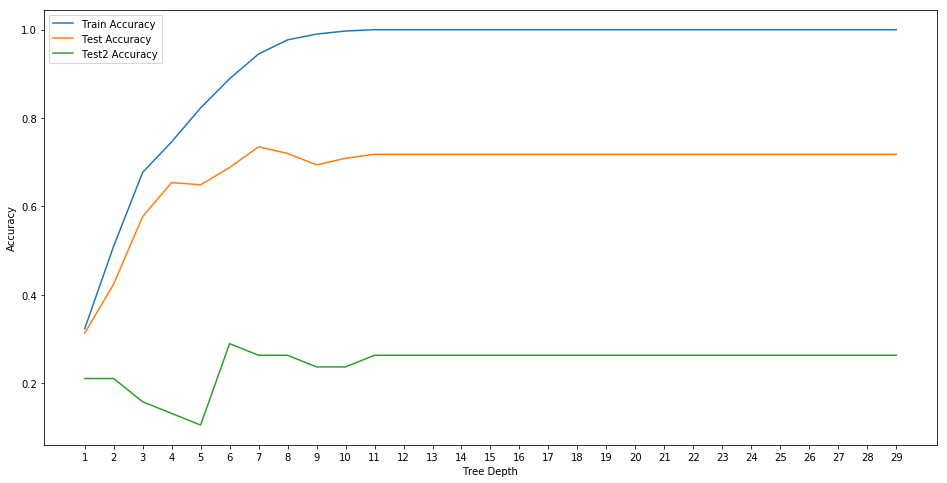

In [19]:
import matplotlib.pyplot as plt

# Model training and accuracy computation for different maximum_depth parameters
tree_depth = [i for i in range(1, 30)]
accs_train = []
accs_test  = []
accs_test2  = []

train_x = img_train[:1000]
train_y = labels_train[:1000]

test_x = img_test[:1000]
test_y = labels_test[:1000]

test2_x, test2_y = read_test()

for depth in tree_depth:
    clf = DecisionTreeClassifier(random_state = 0, max_depth = depth)
    clf.fit(train_x, train_y)
    accs_train.append(clf.score(train_x, train_y))
    accs_test.append(clf.score(test_x, test_y))
    accs_test2.append(clf.score(test2_x, test2_y))
plt.figure(figsize=(16, 8))

print("Tree depth: " + str(tree_depth[np.argmax(accs_test)]))

# Draw accuracies as a function of the depth for both trainin and testing sets
plt.plot(tree_depth, accs_train, label = 'Train Accuracy')
plt.plot(tree_depth, accs_test,  label = 'Test Accuracy')
plt.plot(tree_depth, accs_test2,  label = 'Test2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Tree Depth')
plt.legend()
plt.xticks(tree_depth)
plt.show()  

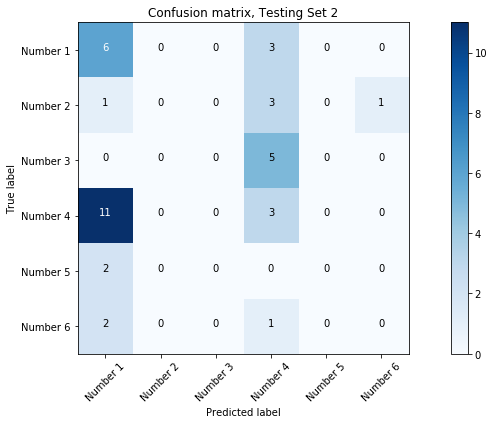

In [23]:
from sklearn.metrics import confusion_matrix

class_names = ['Number 1', 'Number 2', 'Number 3','Number 4', 'Number 5', 'Number 6']
plt.figure(figsize=(12,6))

Ypred_train = clf.predict(train_x)
Ypred_test = clf.predict(test_x)
Ypred2_test = clf.predict(test2_x)

'''
# Computation of confusion matrix on training set
cm = confusion_matrix(train_y, Ypred_train)
plt.subplot(121)
plot_confusion_matrix(cm, classes=class_names,title='Confusion matrix, Training Set')
'''

'''
# Computation of confusion matrix on testing set
cm = confusion_matrix(test_y, Ypred_test)
plt.subplot(121)
plot_confusion_matrix(cm, classes=class_names,title='Confusion matrix, Testing Set')
plt.show()
'''

# Computation of confusion matrix on testing set
cm = confusion_matrix(test2_y, Ypred2_test)
#plt.subplot(122)
plot_confusion_matrix(cm, classes=class_names,title='Confusion matrix, Testing Set 2')
plt.show()

## **Random Forest Classifier**

Tree depth: 21


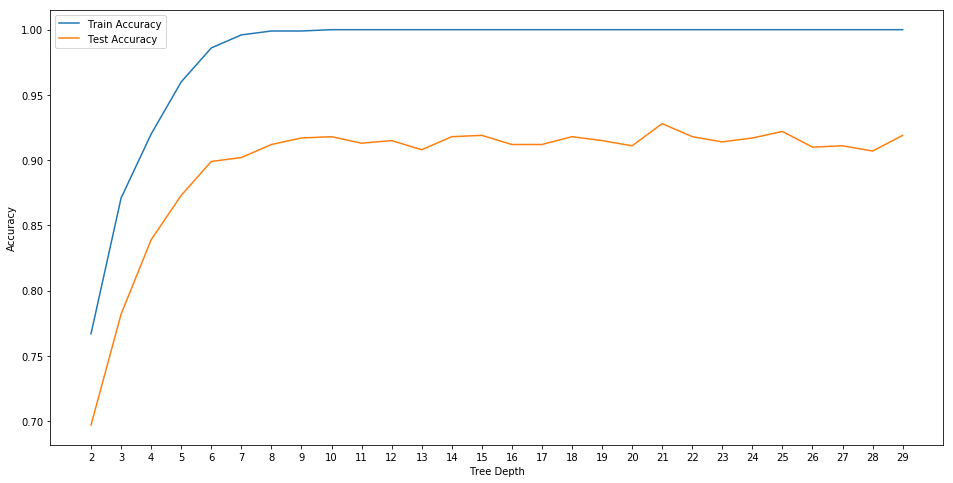

'\nestimators = [i for i in range(1,100)]\naccs_train = []\naccs_test  = []\n\nfor estim in estimators:\n    clf = RandomForestClassifier(n_estimators = estim, max_depth = max_value)\n    clf.fit(train_x, train_y)\n    accs_train.append(clf.score(train_x, train_y))\n    accs_test.append(clf.score(test_x, test_y))\n\nprint("N\xc2\xba estimators: " + str(estimators[np.argmax(accs_test)]))\n\nplt.figure(figsize=(16, 8))\n# Draw accuracies as a function of the depth for both trainin and testing sets\nplt.plot(estimators, accs_train, label = \'Train Accuracy\')\nplt.plot(estimators, accs_test,  label = \'Test Accuracy\')\nplt.ylabel(\'Accuracy\')\nplt.xlabel(\'N trees\')\nplt.legend()\nplt.xticks(estimators)\nplt.show()  \n'

In [24]:
import matplotlib.pyplot as plt

# Model training and accuracy computation for different maximum_depth parameters
tree_depth = [i for i in range(2, 30)]
accs_train = []
accs_test  = []

train_x = img_train[:1000]
train_y = labels_train[:1000]

test_x = img_test[:1000]
test_y = labels_test[:1000]

#img_test2, labels_test2 = read_test()

for depth in tree_depth:
    clf = RandomForestClassifier(n_estimators = 100, max_depth = depth)
    clf.fit(train_x, train_y)
    accs_train.append(clf.score(train_x, train_y))
    accs_test.append(clf.score(test_x, test_y))

max_value = tree_depth[np.argmax(accs_test)]
print("Tree depth: " + str(max_value))


plt.figure(figsize=(16, 8))
# Draw accuracies as a function of the depth for both trainin and testing sets
plt.plot(tree_depth, accs_train, label = 'Train Accuracy')
plt.plot(tree_depth, accs_test,  label = 'Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Tree Depth')
plt.legend()
plt.xticks(tree_depth)
plt.show() 

'''
estimators = [i for i in range(1,100)]
accs_train = []
accs_test  = []

for estim in estimators:
    clf = RandomForestClassifier(n_estimators = estim, max_depth = max_value)
    clf.fit(train_x, train_y)
    accs_train.append(clf.score(train_x, train_y))
    accs_test.append(clf.score(test_x, test_y))

print("Nº estimators: " + str(estimators[np.argmax(accs_test)]))

plt.figure(figsize=(16, 8))
# Draw accuracies as a function of the depth for both trainin and testing sets
plt.plot(estimators, accs_train, label = 'Train Accuracy')
plt.plot(estimators, accs_test,  label = 'Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('N trees')
plt.legend()
plt.xticks(estimators)
plt.show()  
'''

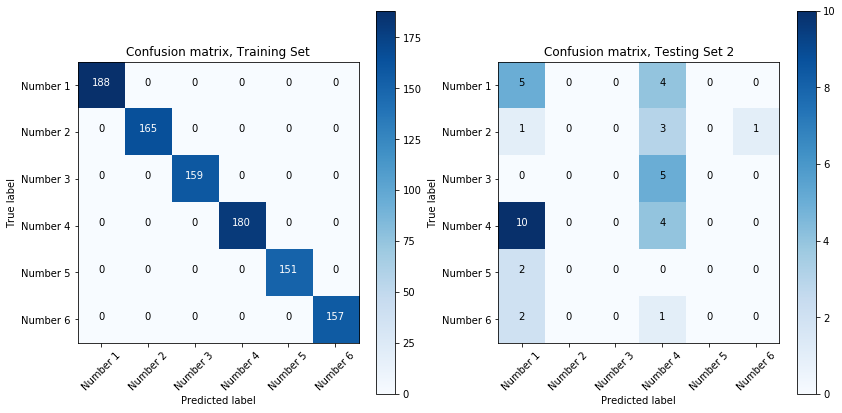

In [25]:
from sklearn.metrics import confusion_matrix

class_names = ['Number 1', 'Number 2', 'Number 3','Number 4', 'Number 5', 'Number 6']
plt.figure(figsize=(12,6))

Ypred_train = clf.predict(train_x)
Ypred_test = clf.predict(test_x)
Ypred2_test = clf.predict(test2_x)

# Computation of confusion matrix on training set
cm = confusion_matrix(train_y, Ypred_train)
plt.subplot(121)
plot_confusion_matrix(cm, classes=class_names,title='Confusion matrix, Training Set')

'''
# Computation of confusion matrix on testing set
cm = confusion_matrix(test_y, Ypred_test)
plt.subplot(122)
plot_confusion_matrix(cm, classes=class_names,title='Confusion matrix, Testing Set')
plt.show()
'''
# Computation of confusion matrix on testing set
cm = confusion_matrix(test2_y, Ypred2_test)
plt.subplot(122)
plot_confusion_matrix(cm, classes=class_names,title='Confusion matrix, Testing Set 2')
plt.show()

## **KNN Classifier**


Tree depth: 19


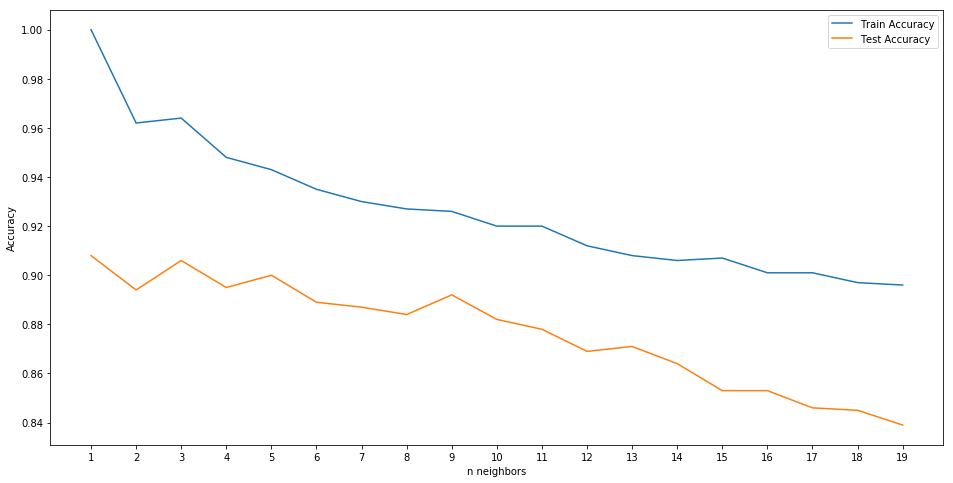

In [53]:
import matplotlib.pyplot as plt

# Model training and accuracy computation for different maximum_depth parameters
neighbors = [i for i in range(1, 20)]
accs_train = []
accs_test  = []

train_x = img_train[:1000]
train_y = labels_train[:1000]

test_x = img_test[:1000]
test_y = labels_test[:1000]

#img_test2, labels_test2 = read_test()

for n in neighbors:
    clf = KNeighborsClassifier(n_neighbors = n)
    clf.fit(train_x, train_y)
    accs_train.append(clf.score(train_x, train_y))
    accs_test.append(clf.score(test_x, test_y))

print("Tree depth: " + str(neighbors[np.argmin(accs_test)]))

plt.figure(figsize=(16, 8))
# Draw accuracies as a function of the depth for both trainin and testing sets
plt.plot(neighbors, accs_train, label = 'Train Accuracy')
plt.plot(neighbors, accs_test,  label = 'Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('n neighbors')
plt.legend()
plt.xticks(neighbors)
plt.show()  

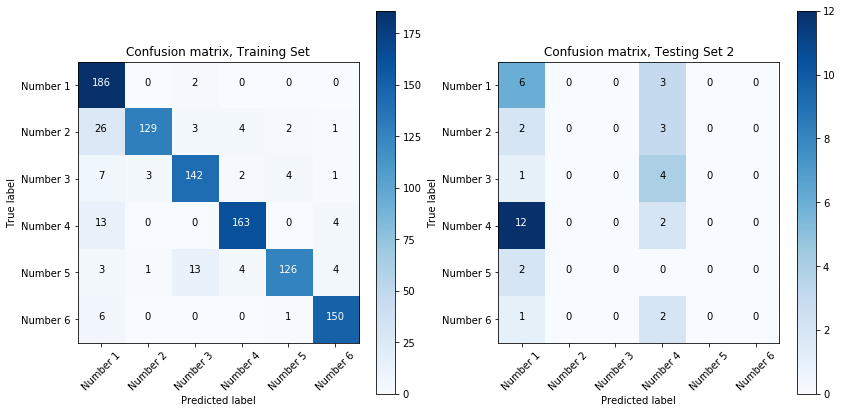

In [54]:
from sklearn.metrics import confusion_matrix

class_names = ['Number 1', 'Number 2', 'Number 3','Number 4', 'Number 5', 'Number 6']
plt.figure(figsize=(12,6))

Ypred_train = clf.predict(train_x)
Ypred_test = clf.predict(test_x)
Ypred2_test = clf.predict(test2_x)

# Computation of confusion matrix on training set
cm = confusion_matrix(train_y, Ypred_train)
plt.subplot(121)
plot_confusion_matrix(cm, classes=class_names,title='Confusion matrix, Training Set')

'''
# Computation of confusion matrix on testing set
cm = confusion_matrix(test_y, Ypred_test)
plt.subplot(122)
plot_confusion_matrix(cm, classes=class_names,title='Confusion matrix, Testing Set')
plt.show()
'''
# Computation of confusion matrix on testing set
cm = confusion_matrix(test2_y, Ypred2_test)
plt.subplot(122)
plot_confusion_matrix(cm, classes=class_names,title='Confusion matrix, Testing Set 2')
plt.show()

## **SVM**

Tree depth: 1


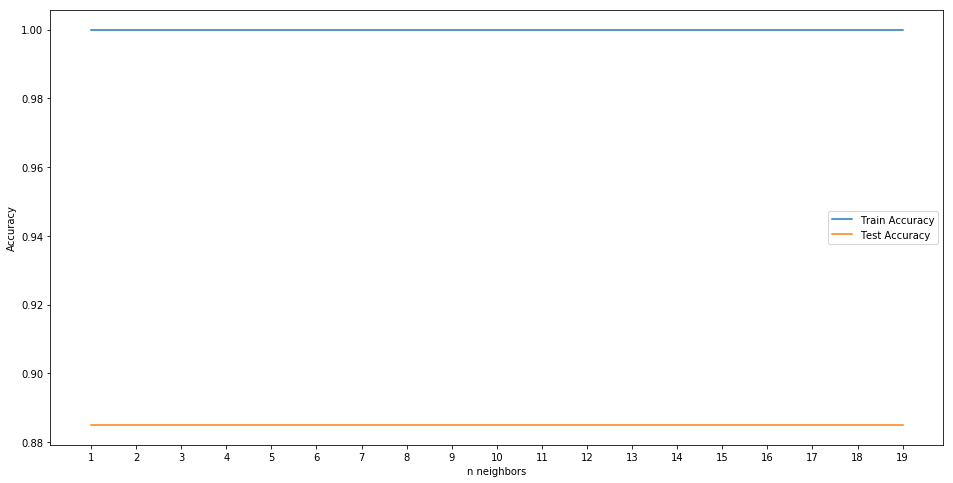

In [27]:
import matplotlib.pyplot as plt

# Model training and accuracy computation for different maximum_depth parameters
neighbors = [i for i in range(1, 20)]
accs_train = []
accs_test  = []

train_x = img_train[:1000]
train_y = labels_train[:1000]

test_x = img_test[:1000]
test_y = labels_test[:1000]

#img_test2, labels_test2 = read_test()

for n in neighbors:
    clf = svm.LinearSVC(random_state=n)
    clf.fit(train_x, train_y)
    accs_train.append(clf.score(train_x, train_y))
    accs_test.append(clf.score(test_x, test_y))

print("Tree depth: " + str(neighbors[np.argmin(accs_test)]))

plt.figure(figsize=(16, 8))
# Draw accuracies as a function of the depth for both trainin and testing sets
plt.plot(neighbors, accs_train, label = 'Train Accuracy')
plt.plot(neighbors, accs_test,  label = 'Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('n neighbors')
plt.legend()
plt.xticks(neighbors)
plt.show()  